# Metadata
Title: Final Project for DS5100 2022  
Date: November 22, 2022  
Name: Alexander Lilly  
Student ID: kzr3fb  
Notebook GitHub URL: https://github.com/alexdlilly/DS-5100-Project-Repo/blob/main/final-project-submission.ipynb  
All Files GitHub URL: https://github.com/alexdlilly/DS-5100-Project-Repo  

# The Monte Carlo Module

In [1]:
import numpy as np
import pandas as pd
class Die:
    """ INITIALIZATION
        INPUTS: 
            faces = a list of possible outcomes for a given random event. For example, for a 6-sided die, faces would 
                    be a list of length 6 where each element represents a face of the dice. By default, the Die class
                    assumes equal probabilistic weights for each possible outcome. 
        ATTRIBUTES:
            Die.faces = a list of possible outcomes associated with the Die object. 
            Die.results = Accesible only after the roll() method has been executed, Die.results returns a dataframe with 
                    the roll number as the index and the value as the outcome of the rolled die. 
        METHODS:
            change_weight(face, new weight): To alter the default equal weight among die faces, pass the face you wish 
            the change the weight of and the weight to which to change it to the change_weight() method. 
            roll(num_rolls): Rolls the die num_rolls times. Stores results of each roll in .results as a dataframe. 
            show_weights(): Returns a dataframe of the die faces and their corresponding weights.  
    """
    def __init__(self, faces):
        self.faces = faces
        self._weight = np.ones(len(faces))
        self._faces_weight = pd.DataFrame({'Faces':self.faces,'Weights':self._weight})
    
    def change_weight(self, face, new_weight):
        """change_weight(face, new weight): To alter the default equal weight among die faces, pass the face you wish 
            the change the weight of and the weight to which to change it to the change_weight() method. """
        if face in self.faces:
            if isinstance(new_weight,float):
                self._faces_weight.loc[self._faces_weight["Faces"] == face, "Weights"] = new_weight
            else:
                try:
                    float(new_weight)
                    self._faces_weight.loc[self._faces_weight["Faces"] == face, "Weights"] = new_weight
                except:
                    raise Exception('New weight must be float or convertable to float!')

        else:
            raise Exception('Face is not in list of faces') 
    
    def roll(self,num_rolls=1):
        """Rolls the die num_rolls times using np.random.choice. Stores results of each roll in .results as a dataframe. """
        self._faces_weight['Probability'] = self._faces_weight['Weights']/self._faces_weight['Weights'].sum()
        outcomes = np.random.choice(self._faces_weight['Faces'],size=num_rolls, p=self._faces_weight['Probability'])
        self.results = pd.DataFrame({'Results':outcomes})
        self.results.index.name = 'Roll'

    def show_weights(self):
        """Returns a dataframe of the die faces and their corresponding weights."""
        return self._faces_weight[['Faces','Weights']]

class Game():
    """ INITIALIZATION
        INPUTS: 
            dies: a list of die objects created by the Die class. Each die object must have the same faces, although each die 
                object can have different weights associated with the die faces. 
        ATTRIBUTES:
            Game.dies: a list of die objects passed through the Game initialization method. 
        METHODS:
            Game.play(N): Rolls each die object N times, stores results in a dataframe Game._results. 
            Game.show(form='Wide'): form = 'Wide' (default) or form = 'Narrow'. If form = 'Wide', Game.show() returns 
                the Game._results dataframe. If form = 'Narrow', Game.show() returns a multi-index array where the roll 
                number and die ID are the indices, and the value are the outcomes of the associates roll number and die ID. 
    """
    def __init__(self, dies):
        if isinstance(dies,list):
            self.dies = dies
        else:
            raise Exception('Dies object must be passed as a list!')
        
    def play(self, N):
        """Rolls each die object N times, stores results in a dataframe Game._results. """
        self._results = pd.DataFrame()
        i = 1
        for die in self.dies:
            die.roll(num_rolls = N)
            self._results[f"Die #{i}"] = die.results['Results'] 
            i += 1

    def show(self,form='Wide'):
        """form = 'Wide' (default) or form = 'Narrow'. If form = 'Wide', Game.show() returns 
                the Game._results dataframe. If form = 'Narrow', Game.show() returns a multi-index array where the roll 
                number and die ID are the indices, and the value are the outcomes of the associates roll number and die ID. """
        if form == 'Wide':
            return self._results
        elif form == 'Narrow':
            self._results['Roll'] = self._results.index
            narrow = pd.wide_to_long(self._results, stubnames = 'Die #',i=["Roll"],j='Die')
            narrow = narrow.rename(columns={'Die #':'Result'})
            return narrow

class Analyzer():
    """ INITIALIZATION
        INPUTS: 
            game: the game object generated by the Game class. 
        ATTRIBUTES:
            Analyzer.game: the game object passed through the Analyzer initialization method. 
            Analyzer.face_counts: Accessible after executing the face_counts_per_roll() method. Analyzer.face_counts is a dataframe
                where each row corresponds to a roll event, and each column is a face of the die object. The values of this dataframe
                correspond to the number of times a given face was rolled in a given roll event. 
            Analyzer.num_jackpots: The number of times all dice rolled the same face. 
            Analyzer.combo: A multi-index dataframe where the indices are different combinations of rolled faces, and the values correspond
                to the number of times those faces were rolled. This dataframe is sorted in descending order, so combinations with the highest
                frequency of occurrence are at the top.  
        METHODS:
            Analyzer.face_counts_per_roll(): Counts the number of each possible face that was rolled for each roll event. Returns the dataframe
                .face_counts. 
            Analyzer.jackpot(): Counts the number of times all dice rolled the same face. Returns the integer .num_jackpots.
            Analyzer.Combo(): Counts the frequency of a given combination of rolled faces, sorted in descending order based on frequency. 
                Returns the dataframe .combo. 

    """
    def __init__(self, game):
        self.game = game
    
    def face_counts_per_roll(self):
        """Counts the number of each possible face that was rolled for each roll event using pd.get_dummies. Returns the dataframe .face_counts. """
        face_counts = self.game.show(form='Narrow')
        face_counts = pd.get_dummies(face_counts.Result)
        self.face_counts = face_counts.groupby(['Roll']).sum()
        return self.face_counts

    def jackpot(self):
        """Counts the number of times all dice rolled the same face. Returns the integer .num_jackpots."""
        self.face_counts_per_roll()
        jackpotdf = self.face_counts.apply(lambda x: np.count_nonzero(x, axis=0),axis=1)
        self.jackpotdf = jackpotdf.loc[jackpotdf == 1]
        num_jackpots = len(self.jackpotdf)
        return num_jackpots
    
    def Combo(self):
        """Counts the frequency of a given combination of rolled faces, sorted in descending order based on frequency. Returns the dataframe .combo. """
        self.face_counts_per_roll()
        self.combo = pd.pivot_table(self.game.show(), index=self.game.show().columns.to_list()[:-1],aggfunc=np.count_nonzero)
        self.combo = self.combo.rename(columns = {'Roll':'Count'})
        self.combo = self.combo.sort_values(by='Count',ascending=False)

# Test Module

In [2]:
from montecarlo import Die, Game, Analyzer
import unittest

class MontecarloTestSuite(unittest.TestCase):

    def test_change_weight(self):
        # Test that the change_weight() method of the Die class correctly changes the weight of the assigned face. 
        faces = [1,2,3,4]
        dice = Die(faces)
        dice.change_weight(3,2)
        df_faces_weights = dice.show_weights()
        assert df_faces_weights['Weights'][2] == 2

    def test_roll(self):
        # Test that the roll() method of the Die class generates a dataframe object with length N for number of rolls. 
        faces = [1,2,3,4]
        dice = Die(faces)
        dice.roll(num_rolls=10)
        assert len(dice.results) == 10

    def test_play(self):
        # Test that the play() method of the Game class generates a dataframe object with length N for number of rolls. 
        faces = [1,2,3,4]
        dice = Die(faces)
        game = Game([dice])
        game.play(10)
        assert len(game._results) == 10

    def test_show_wide(self):
        # Test that the show() method of the Game class generates a wide form dataframe object with length N for number of rolls and width W for number of dice. 
        faces = [1,2,3,4]
        dice = Die(faces)
        game = Game([dice,dice,dice])
        game.play(10)
        df = game.show()
        assert (df.shape[0] == 10 and df.shape[1]==3)     

    def test_show_narrow(self):
        # Test that the show() method of the Game class generates a narrow form dataframe object with length N x W for number of rolls N and number of dice W. 
        faces = [1,2,3,4]
        dice = Die(faces)
        game = Game([dice,dice,dice])
        game.play(10)
        df = game.show(form='Narrow')
        assert (len(df) == 30)

    def test_face_counts_per_roll(self):
        # Tests that the face_counts_per_roll() method of the Analyzer class produces a dataframe of size N x F for number of rolls N and number of faces F, and has an internal sum of values (face counts) equal to N x W for N number of rolls and W number of dice. 
        faces = [1,2,3,4,5]
        dice = Die(faces)
        game = Game([dice,dice,dice])
        game.play(20)
        Analysis=Analyzer(game)
        df = Analysis.face_counts_per_roll()
        shape = df.shape
        internal_sum = df.sum().sum()
        assert (shape[0]==20 and shape[1]==5 and internal_sum==60)

    def test_jackpot(self):
        # Tests that the jackpot() method of the Analyzer class returns an integer. 
        faces = [1,2,3,4,5]
        dice = Die(faces)
        game = Game([dice,dice,dice])
        game.play(20)
        Analysis=Analyzer(game)
        assert isinstance(Analysis.jackpot(),int) == True

    def test_combo(self):
        # Tests that the combo() method of the Analyzer class returns a dataframe of only 1 column with a sum of combinations equal to the number of rolls minus 1. 
        faces = [1,2,3,4,5,6]
        dice = Die(faces)
        game = Game([dice,dice,dice,dice,dice])
        game.play(1000)
        Analysis=Analyzer(game)
        Analysis.Combo()
        assert(Analysis.combo.shape[1]==1 and Analysis.combo['Count'].sum()==999)
                   


# Test Results

In [3]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_change_weight (__main__.MontecarloTestSuite) ... ok
test_combo (__main__.MontecarloTestSuite) ... ok
test_face_counts_per_roll (__main__.MontecarloTestSuite) ... ok
test_jackpot (__main__.MontecarloTestSuite) ... ok
test_play (__main__.MontecarloTestSuite) ... ok
test_roll (__main__.MontecarloTestSuite) ... ok
test_show_narrow (__main__.MontecarloTestSuite) ... ok
test_show_wide (__main__.MontecarloTestSuite) ... ok

----------------------------------------------------------------------
Ran 8 tests in 0.067s

OK


# Scenarios

## Scenario 1: 2-headed Coin

In [4]:
from montecarlo import Die, Game, Analyzer

In [5]:
Faces = ['H','T']
Fair = Die(Faces)
Unfair = Die(Faces)
Unfair.change_weight('H',5)

Play a game of 1,000 flips with three coins with all fair dice. 

In [6]:
Game = Game([Fair,Fair,Fair])
Game.play(1000)
Analysis = Analyzer(Game)
Fair_Jackpot = Analysis.jackpot()/1000
print(Fair_Jackpot)

0.24


Play a game of 1,000 flips with three coins with two unfair dice and one fair die

In [7]:
from montecarlo import Game
Unfair_Game = Game([Unfair,Fair,Unfair])
Unfair_Game.play(1000)
Analysis = Analyzer(Unfair_Game)
Unfair_Jackpot = Analysis.jackpot()/1000
print(Unfair_Jackpot)

0.332


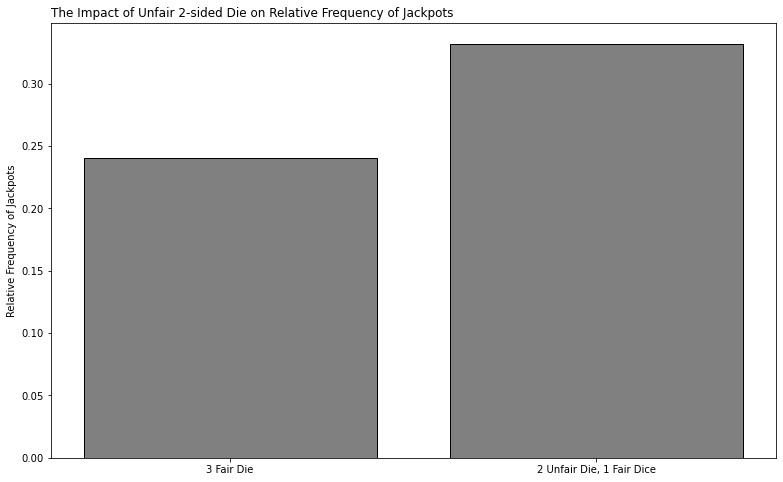

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,8))
plt.bar(['3 Fair Die','2 Unfair Die, 1 Fair Dice'],[Fair_Jackpot, Unfair_Jackpot],color='gray',edgecolor='black')
plt.ylabel('Relative Frequency of Jackpots')
plt.title('The Impact of Unfair 2-sided Die on Relative Frequency of Jackpots',loc='left')
plt.show()

## Scenario 2: 6-sided Die

In [9]:
from montecarlo import Die, Game, Analyzer

In [10]:
Faces = [1,2,3,4,5,6]
Die1 = Die(Faces)
Die1.change_weight(6,5)
Die2 = Die(Faces)
Die2.change_weight(1,5)
Die = Die(Faces)

In [11]:
Fair_Game = Game([Die, Die, Die, Die, Die])
Fair_Game.play(10000)
Analysis = Analyzer(Fair_Game)
Fair_Jackpots = Analysis.jackpot()/10000
Analysis.Combo()
Fair_Combo = Analysis.combo[:10]

In [12]:
from montecarlo import Game
Unfair_Game = Game([Die1,Die1,Die2,Die,Die])
Unfair_Game.play(10000)
Analysis = Analyzer(Unfair_Game)
Unfair_Jackpots = Analysis.jackpot()/10000
Analysis.Combo()
Unfair_Combo = Analysis.combo[:10]


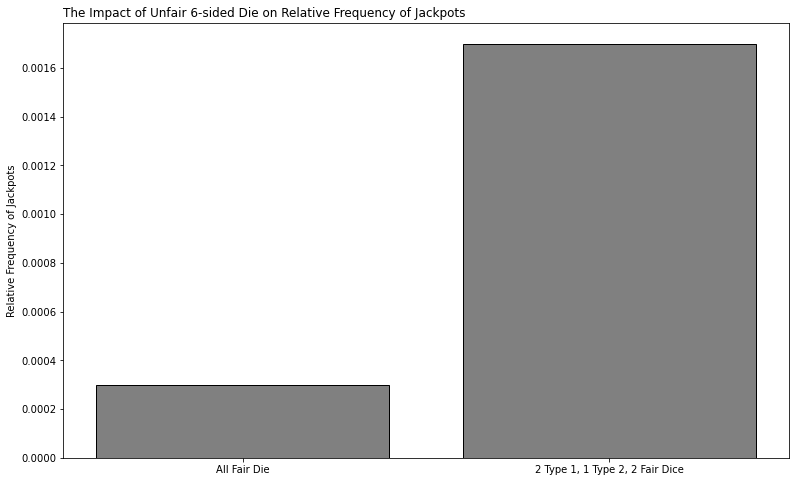

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,8))
plt.bar(['All Fair Die','2 Type 1, 1 Type 2, 2 Fair Dice'],[Fair_Jackpots, Unfair_Jackpots],color='gray',edgecolor='black')
plt.ylabel('Relative Frequency of Jackpots')
plt.title('The Impact of Unfair 6-sided Die on Relative Frequency of Jackpots',loc='left')
plt.show()


## Scenario 3: Roman Alphabet

In [14]:
import pandas as pd
import numpy as np
from montecarlo import Die, Game, Analyzer

Alphabet = pd.read_csv('roman_alphabet.txt',delimiter='\t',header=None,names=['Letter','Weight'])
Alphabet['Letter'] = Alphabet['Letter'].astype('str')

In [15]:
Die = Die(Alphabet['Letter'].tolist())

for i in range(len(Alphabet)):
    Die.change_weight(Alphabet['Letter'].iloc[i], Alphabet['Weight'].iloc[i])

In [16]:
Game = Game([Die, Die, Die, Die, Die])
Result_list = []
for i in range(10):
    rand_list = np.random.randint(1000,size=10)
    Game.play(1000)
    Result_list.append(Game.show().iloc[rand_list])
    

In [17]:
Result_list

[     Die #1 Die #2 Die #3 Die #4 Die #5
 Roll                                   
 469       N      I      S      U      W
 547       W      H      O      R      M
 294       C      S      R      Y      I
 338       F      D      O      M      I
 864       K      M      A      A      A
 526       Y      C      N      S      S
 562       O      I      S      O      S
 605       M      T      G      B      S
 732       A      E      N      C      H
 307       L      I      U      R      W,
      Die #1 Die #2 Die #3 Die #4 Die #5
 Roll                                   
 244       L      N      A      T      Z
 89        E      E      C      A      S
 161       C      H      I      O      I
 158       L      M      A      I      L
 573       E      C      G      U      S
 187       E      H      R      L      Y
 650       E      R      F      R      R
 368       R      A      H      V      L
 695       E      O      T      Q      A
 471       H      O      I      R      Z,
      Die #1 D

# Directory Listing

In [55]:
%%powershell
cd..
cd Montecarlo
Get-ChildItem -Recurse



    Directory: C:\Users\alexa\DS-5100-Project-Repo\Montecarlo


Mode                 LastWriteTime         Length Name                                                                 
----                 -------------         ------ ----                                                                 
d-----         11/5/2022   5:27 PM                montecarlo                                                           
d-----         11/5/2022   5:42 PM                montecarlo.egg-info                                                  
d-----         11/5/2022   5:24 PM                tests                                                                
-a----         11/5/2022   5:34 PM            464 setup.py                                                             


    Directory: C:\Users\alexa\DS-5100-Project-Repo\Montecarlo\montecarlo


Mode                 LastWriteTime         Length Name                                                                 
----             

# Installation Output Listing

In [62]:
%%powershell
cd..
cd Montecarlo
pip install -e.

Obtaining file:///C:/Users/alexa/DS-5100-Project-Repo/Montecarlo
  Attempting uninstall: montecarlo
    Found existing installation: montecarlo 1.0.0
    Uninstalling montecarlo-1.0.0:
      Successfully uninstalled montecarlo-1.0.0
  Running setup.py develop for montecarlo
